# CTA 4.0 - Optimization 1.0

In [1]:
import warnings

import pandas as pd
import numpy as np

from cvx.simulator import Portfolio
from cvx.simulator import interpolate

from tinycta.signal import osc, returns_adjust

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
# Load prices
prices = pd.read_csv("data/Prices_hashed.csv", index_col=0, parse_dates=True)

# interpolate the prices
prices = prices.apply(interpolate)

In [3]:
from ipywidgets import Label, HBox, VBox, IntSlider, FloatSlider

fast = IntSlider(min=4, max=192, step=4, value=32)
slow = IntSlider(min=4, max=192, step=4, value=96)
vola = IntSlider(min=4, max=192, step=4, value=32)
winsor = FloatSlider(min=1.0, max=6.0, step=0.1, value=4.2)
left_box = VBox(
    [
        Label("Fast Moving Average"),
        Label("Slow Moving Average"),
        Label("Volatility"),
        Label("Winsorizing"),
    ]
)
right_box = VBox([fast, slow, vola, winsor])
HBox([left_box, right_box])

In [4]:
mu = np.tanh(
    prices.apply(returns_adjust, com=vola.value, clip=winsor.value)
    .cumsum()
    .apply(osc, fast=fast.value, slow=slow.value)
)
volax = prices.pct_change().ewm(com=vola.value, min_periods=vola.value).std()

# compute the series of Euclidean norms by compute the sum of squares for each row
euclid_norm = np.sqrt((mu * mu).sum(axis=1))

# Divide each column of mu by the Euclidean norm
risk_scaled = mu.apply(lambda x: x / euclid_norm, axis=0)

pos = 5e5 * risk_scaled / volax
portfolio = Portfolio.from_cashpos_prices(prices=prices, cashposition=pos, aum=1e8)

/Users/a13069q/cs/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


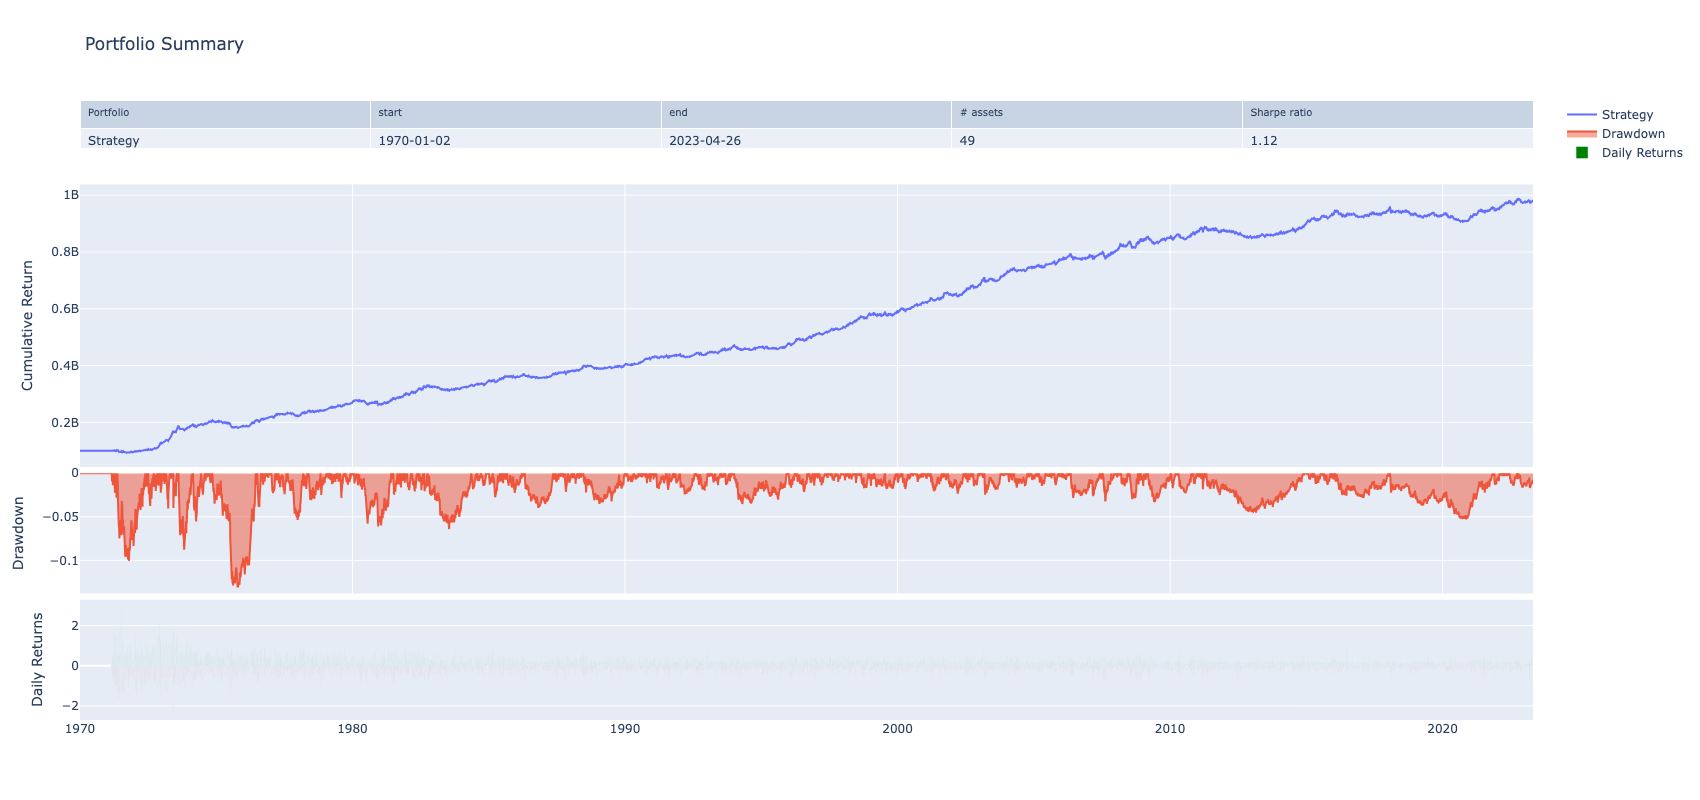

In [5]:
portfolio.snapshot()